In this notebook, we extract morphological features from preprocessed cell masks — specifically area, perimeter, and circularity — using `skimage.measure.regionprops`. These features are standardized and reduced to two principal components using PCA to capture the most variance in shape characteristics.

We then apply KMeans clustering to group cells based on their morphology in PCA space. The resulting scatter plot visualizes cluster separation, centroid positions, and annotated outliers, offering insight into structural diversity among synthetic cells.

This step bridges raw image data with interpretable clustering, forming the core of the CellMorph Explorer pipeline.

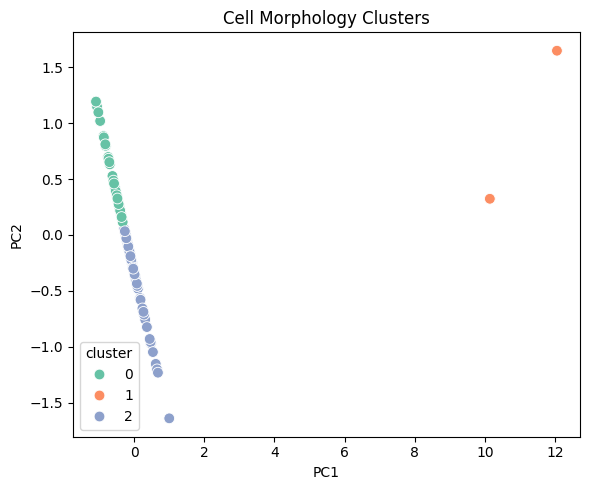

Explained variance by PCA components:
PC1: 88.36%
PC2: 11.53%


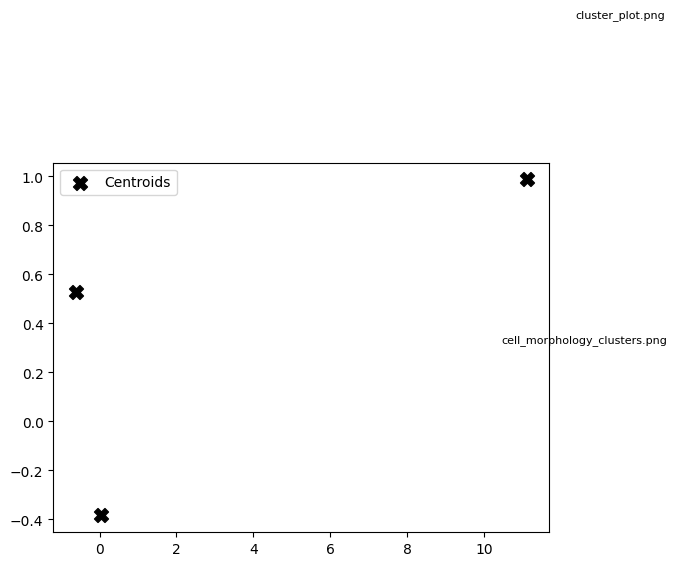

In [13]:
import pandas as pd
import cv2
import os
import numpy as np
from skimage.measure import regionprops, label
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


features = []

for fname in os.listdir("results/plots"):
    img = cv2.imread(f"results/plots/{fname}", 0)
    lbl = label(img)
    props = regionprops(lbl)[0]
    area = props.area
    perimeter = props.perimeter
    circularity = 4 * np.pi * area / (perimeter ** 2)
    features.append({
        "cell_id": fname,
        "area": area,
        "perimeter": perimeter,
        "circularity": circularity
    })

df = pd.DataFrame(features)
df.to_csv("results/cell_features.csv", index=False)


X = df[["area", "perimeter", "circularity"]]
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=3, random_state=42)
df["cluster"] = kmeans.fit_predict(X_pca)
df.to_csv("results/cell_clusters.csv", index=False)

plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df["cluster"], palette="Set2", s=60)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Cell Morphology Clusters")
plt.tight_layout()
plt.savefig("results/plots/cell_morphology_clusters.png")
plt.show()


print("Explained variance by PCA components:")
print(f"PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"PC2: {pca.explained_variance_ratio_[1]:.2%}")


centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], 
            marker="X", s=100, c="black", label="Centroids")

for i, (x, y) in enumerate(X_pca):
    if x > 10 or x < -10 or y > 5 or y < -5:  
        plt.text(x + 0.3, y, df["cell_id"].iloc[i], fontsize=8, color="black")

plt.legend()
plt.savefig("results/plots/cell_morphology_clusters_annotated.png")
plt.show()
